# Neural Style Transfer

We'll describe an implementation of DeepDream.

In [1]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load the example image of the Drosophila ssTEM dataset from https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713. Alternatively, you can download an image from the corresponding GiHub repository: http://github.com/unidesigner/groundtruth-drosophila-vnc.

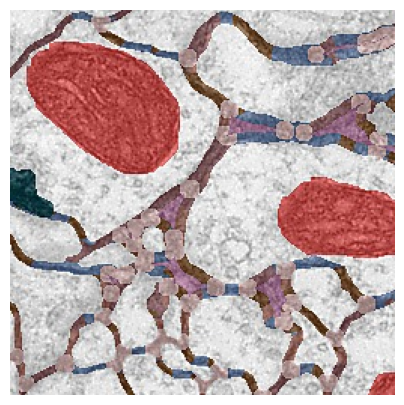

In [2]:
from PIL import Image
from urllib.request import urlopen
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

image_size = (256, 256)

url = 'https://s3-eu-west-1.amazonaws.com/pfigshare-u-previews/1288336/preview.jpg'

width = image_size[0]
height = image_size[1]
left = 100
top = 170

im_c = Image.open(urlopen(url)).crop((left,top,left + width, top + height))

from style_transfer import plot_example
plot_example(im_c)

We'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona)

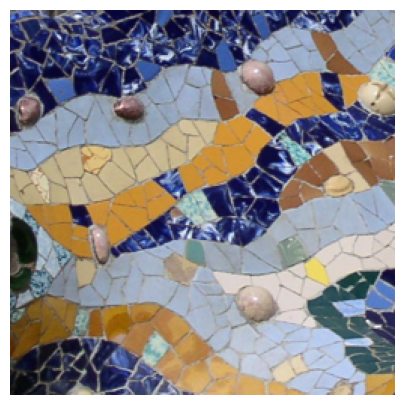

In [3]:
url = 'https://upload.wikimedia.org/wikipedia/commons/d/da/Reptil_Parc_Guell_Barcelona.jpg'

width = 512
height = 512
left = 800
top = 250

im_s = Image.open(urlopen(url)).crop((left,top,left + width, top + height)).resize(image_size)

plot_example(im_s)

In [4]:
def gram_matrix(input):
    import torch
    b, c, h, w = input.size()
    F = input.view(b,c,h*w)
    G = torch.bmm(F, F.transpose(1,2))/(h*w)
    return G

We'll download a pretrained model (VGG16).

In [5]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

print(model)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset.

In [6]:
import numpy as np
mean_ds = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_ds = np.array([0.229, 0.224, 0.225], dtype=np.float32)

We'll define a function that perform loss maximization through gradient ascend. 

In [7]:
def style_transfer(im_in, im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 1e3, num_iterations=100):

    import torch
    from style_transfer import fwd_hooks, preprocess, deprocess, plot_style
    import numpy as np
    from PIL import Image

    # content
    image_c = preprocess(im_c, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_c)
    content_features = [fh.stored[i].detach() for i in ind_c]

    # style
    image_s = preprocess(im_s, mean_ds, std_ds)
    with fwd_hooks(layers) as fh:
        out = model(image_s)
    style_features = [fh.stored[i].detach() for i in ind_s]
    gram_targets = [gram_matrix(s) for s in style_features]

    #input
    try: im_in.verify()
    except: 
        print('Input image not provided. Using a random input.')
        imarray = np.random.rand(*image_size,3) * 255
        im_in = Image.fromarray(imarray.astype('uint8')).convert('RGB')
    
    image_in = preprocess(im_in, mean_ds, std_ds).requires_grad_(True)
    
    optimizer = torch.optim.LBFGS([image_in], lr = lr)
    mse_loss = torch.nn.MSELoss(reduction='sum')

    model.eval()
    model.requires_grad_(False)

    l_c = []
    l_s = []

    for it in range(num_iterations):
        def closure():
            optimizer.zero_grad()

            # content & style
            with fwd_hooks(layers) as fh:
                out = model(image_in)
            content_features_in = [fh.stored[i] for i in ind_c]
            style_features_in = [fh.stored[i] for i in ind_s]
            gram_in = [gram_matrix(i) for i in style_features_in]

            c_loss = 0
            for i,c in enumerate(content_features_in):
                n_f = c.shape[1]
                c_loss += mse_loss(c,content_features[i])/n_f**2
            c_loss /= len(content_features_in)

            s_loss = 0
            for i,g in enumerate(gram_in):
                n_g = g.shape[1]
                s_loss += mse_loss(g,gram_targets[i])/n_g**2
            s_loss /= len(gram_in)

            loss = c_loss + beta*s_loss
            l_c.append(c_loss)
            l_s.append(s_loss)

            loss.backward()
            return loss

        optimizer.step(closure)
        print('Step {}: Content Loss: {:.8f} Style Loss: {:.8f}'.format(it, l_c[-1], l_s[-1]))

        # if (it+1)%5 == 0:
        #     im_out = Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB') 
        #     plot_style(im_c, im_s, im_out)
    return Image.fromarray(np.uint8(np.clip(deprocess(image_in.data.clone().detach(), mean_ds, std_ds)*255,0,255)), 'RGB')

We'll apply the style transfer using as an input the same image used to get the content.

Step 0: Content Loss: 238.95104980 Style Loss: 0.15961245
Step 1: Content Loss: 284.71078491 Style Loss: 0.08872531
Step 2: Content Loss: 310.07748413 Style Loss: 0.04402725
Step 3: Content Loss: 323.70169067 Style Loss: 0.03113591
Step 4: Content Loss: 332.78421021 Style Loss: 0.02465678
Step 5: Content Loss: 340.01617432 Style Loss: 0.01806645
Step 6: Content Loss: 343.77801514 Style Loss: 0.01460767
Step 7: Content Loss: 344.41320801 Style Loss: 0.01300017
Step 8: Content Loss: 348.09548950 Style Loss: 0.01053329
Step 9: Content Loss: 349.35583496 Style Loss: 0.00917815
Step 10: Content Loss: 349.33862305 Style Loss: 0.00832043
Step 11: Content Loss: 350.42730713 Style Loss: 0.00731082
Step 12: Content Loss: 350.50790405 Style Loss: 0.00655684
Step 13: Content Loss: 348.86840820 Style Loss: 0.00614165
Step 14: Content Loss: 349.76306152 Style Loss: 0.00547173
Step 15: Content Loss: 349.25653076 Style Loss: 0.00504847
Step 16: Content Loss: 348.59912109 Style Loss: 0.00470645
Step 17

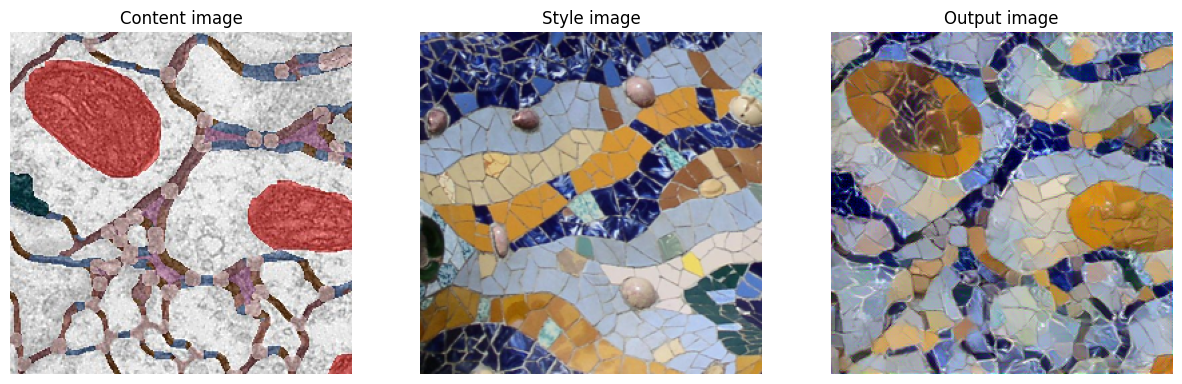

In [10]:
from style_transfer import plot_style

ind = [0, 2, 5, 7, 10, 12, 14, 17]
layers = [model.features[i] for i in ind ] 
ind_c = [5]
ind_s = [0, 1, 2, 3, 4]

im_out  =  style_transfer(im_c, im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 1e5, num_iterations=50)
plot_style(im_c, im_s, im_out)

We'll also apply the style transfer using as an input a random image.

Input image not provided. Using a random input.
Step 0: Content Loss: 544.90734863 Style Loss: 0.45612708
Step 1: Content Loss: 550.65008545 Style Loss: 0.11573281
Step 2: Content Loss: 515.07745361 Style Loss: 0.07808788
Step 3: Content Loss: 496.58554077 Style Loss: 0.04828867
Step 4: Content Loss: 467.56872559 Style Loss: 0.03650317
Step 5: Content Loss: 434.28811646 Style Loss: 0.03263932
Step 6: Content Loss: 417.22131348 Style Loss: 0.02538875
Step 7: Content Loss: 396.48883057 Style Loss: 0.02243201
Step 8: Content Loss: 373.88665771 Style Loss: 0.01995600
Step 9: Content Loss: 356.63760376 Style Loss: 0.01863701
Step 10: Content Loss: 342.93774414 Style Loss: 0.01709361
Step 11: Content Loss: 331.85690308 Style Loss: 0.01586863
Step 12: Content Loss: 318.75567627 Style Loss: 0.01658005
Step 13: Content Loss: 311.68212891 Style Loss: 0.01437694
Step 14: Content Loss: 300.75598145 Style Loss: 0.01407033
Step 15: Content Loss: 294.98529053 Style Loss: 0.01311227
Step 16: Content L

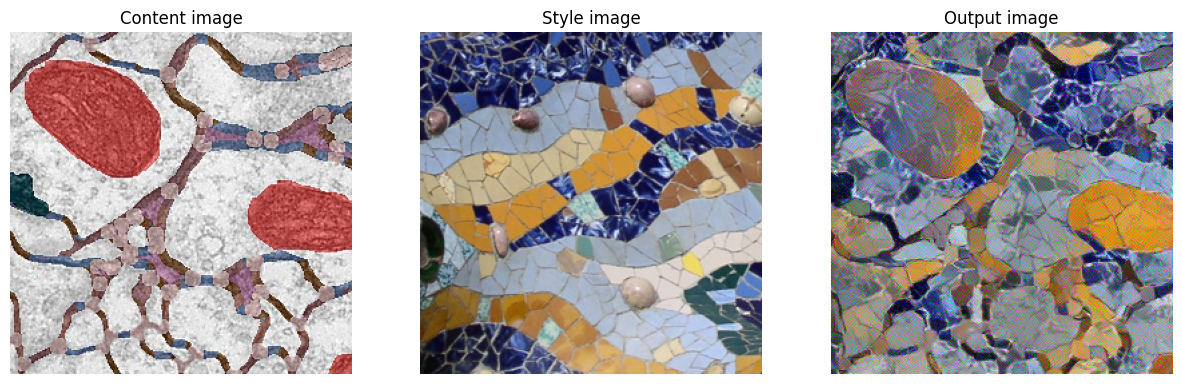

In [11]:
im_out  =  style_transfer([],im_c, im_s, layers, ind_c, ind_s, lr = 1, beta = 5e3, num_iterations=50)
plot_style(im_c, im_s, im_out)